<a href="https://colab.research.google.com/github/Kamal-Raj1/Kamal-Raj1/blob/main/DIP_MINOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!unzip "/content/drive/MyDrive/archive (9).zip"

Archive:  /content/drive/MyDrive/archive (9).zip
replace signatures/Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
# Cell 2: Imports and basic config
import os, re
from glob import glob
from collections import defaultdict
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import pandas as pd

from skimage.feature import hog
from skimage.morphology import skeletonize

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

# Reproducibility
RANDOM_STATE = 5962
np.random.seed(RANDOM_STATE)

# Paths (edit if your data path differs)
SIGN_ROOT = "/content/signatures"   # expects full_org and full_forg here
OUT_DIR = "/content/signature_results"
MODEL_DIR = os.path.join(OUT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)


In [10]:
# Cell 3: Preprocessor
class Preprocessor:
    def __init__(self, target_size=(128,64), blur_ksize=(3,3),
                 adaptive_block=25, adaptive_C=8, morph_kernel=(2,2)):
        # target_size: (width, height)
        self.target_w, self.target_h = target_size
        self.blur_ksize = blur_ksize
        self.adaptive_block = adaptive_block
        self.adaptive_C = adaptive_C
        self.morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)

    def read_gray(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Cannot read image: {path}")
        return img

    def adaptive_binarize(self, img):
        img_blur = cv2.GaussianBlur(img, self.blur_ksize, 0)
        th = cv2.adaptiveThreshold(img_blur, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV,
                                   self.adaptive_block, self.adaptive_C)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, self.morph_kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, self.morph_kernel)
        return th

    def crop_and_pad(self, img_bin):
        ys, xs = np.where(img_bin > 0)
        if len(xs) == 0 or len(ys) == 0:
            out = cv2.resize(img_bin, (self.target_w, self.target_h))
            return out
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        crop = img_bin[y_min:y_max+1, x_min:x_max+1]
        h, w = crop.shape
        scale = min(self.target_w / float(w), self.target_h / float(h))
        new_w, new_h = max(1, int(w * scale)), max(1, int(h * scale))
        resized = cv2.resize(crop, (new_w, new_h))
        pad_w1 = (self.target_w - new_w) // 2
        pad_w2 = self.target_w - new_w - pad_w1
        pad_h1 = (self.target_h - new_h) // 2
        pad_h2 = self.target_h - new_h - pad_h1
        out = cv2.copyMakeBorder(resized, pad_h1, pad_h2, pad_w1, pad_w2,
                                 cv2.BORDER_CONSTANT, value=0)
        return out

    def preprocess(self, path, return_skeleton=False):
        img = self.read_gray(path)
        bin_img = self.adaptive_binarize(img)
        cropped = self.crop_and_pad(bin_img)
        if return_skeleton:
            bw = (cropped > 0).astype(np.uint8)
            sk = skeletonize(bw).astype(np.uint8) * 255
            return cropped, sk
        return cropped


In [11]:
# Cell 4: HOGExtractor
class HOGExtractor:
    def __init__(self, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm='L2-Hys'):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def extract(self, img):
        fd = hog(img, orientations=self.orientations,
                 pixels_per_cell=self.pixels_per_cell,
                 cells_per_block=self.cells_per_block,
                 block_norm=self.block_norm,
                 visualize=False, feature_vector=True)
        return fd


In [12]:
# Cell 5: SignatureDatasetFromTwoFolders (uses full_org and full_forg)
class SignatureDatasetFromTwoFolders:
    def __init__(self, signatures_root, preprocessor:Preprocessor, hog_extractor:HOGExtractor):
        self.root = signatures_root
        self.org_dir = os.path.join(signatures_root, "full_org")
        self.forg_dir = os.path.join(signatures_root, "full_forg")
        self.pre = preprocessor
        self.hog = hog_extractor
        self.data = {}

    @staticmethod
    def extract_writer_id(filename):
        name = os.path.basename(filename)
        name_noext = os.path.splitext(name)[0]
        m = re.search(r'(\d+)', name_noext)
        if m:
            return f"writer_{m.group(1)}"
        parts = re.split(r'[_\-]', name_noext)
        if len(parts) > 0 and parts[0] != '':
            return f"writer_{parts[0]}"
        return f"writer_{name_noext}"

    def discover(self):
        if not os.path.isdir(self.org_dir):
            raise ValueError(f"Missing genuine folder: {self.org_dir}")
        if not os.path.isdir(self.forg_dir):
            raise ValueError(f"Missing forgery folder: {self.forg_dir}")

        writers = defaultdict(lambda: {'genuine': [], 'forgery': []})
        org_files = sorted(glob(os.path.join(self.org_dir, "*.*")))
        for p in org_files:
            wid = self.extract_writer_id(p)
            writers[wid]['genuine'].append(p)
        forg_files = sorted(glob(os.path.join(self.forg_dir, "*.*")))
        for p in forg_files:
            wid = self.extract_writer_id(p)
            writers[wid]['forgery'].append(p)
        self.data = {w: dat for w, dat in writers.items() if len(dat['genuine']) > 0}

    def summary(self, n_show=8):
        print(f"Found {len(self.data)} writers (after grouping).")
        total_g = sum(len(v['genuine']) for v in self.data.values())
        total_f = sum(len(v['forgery']) for v in self.data.values())
        print(f"Total genuine images: {total_g} | Total forgeries: {total_f}\n")
        print("Sample writer -> counts and example files:")
        for w, dat in list(self.data.items())[:n_show]:
            print(f"  {w}: genuines={len(dat['genuine'])}, forgeries={len(dat['forgery'])}")
            print(f"    genuine example: {os.path.basename(dat['genuine'][0])}")
            if len(dat['forgery'])>0:
                print(f"    forgery example: {os.path.basename(dat['forgery'][0])}")

    def compute_hog_features(self):
        X, y_writer, filepaths = [], [], []
        for w, parts in (self.data.items()):
            for p in parts['genuine']:
                img = self.pre.preprocess(p)
                fd = self.hog.extract(img)
                X.append(fd); y_writer.append(w); filepaths.append(p)
            for p in parts['forgery']:
                img = self.pre.preprocess(p)
                fd = self.hog.extract(img)
                X.append(fd); y_writer.append('FORGERY_'+w); filepaths.append(p)
        if len(X) == 0:
            return np.empty((0,)), [], []
        X = np.vstack(X)
        return X, y_writer, filepaths

    def build_enrollment_prototypes(self, enroll_k=5):
        prototypes = {}; enroll_paths = {}
        for w, parts in self.data.items():
            genuines = parts['genuine']
            if len(genuines) < 1: continue
            enroll_list = genuines[:min(enroll_k, len(genuines))]
            feats = []
            for p in enroll_list:
                fd = self.hog.extract(self.pre.preprocess(p))
                feats.append(fd)
            feats = np.vstack(feats)
            proto = feats.mean(axis=0); proto = proto / (np.linalg.norm(proto)+1e-10)
            prototypes[w] = proto
            enroll_paths[w] = enroll_list
        return prototypes, enroll_paths


In [13]:
# Cell 6: Metrics utilities
def compute_far_frr_at_threshold(y_true, y_scores, threshold):
    """
    y_true: 1 for genuine, 0 for forgery
    y_scores: higher means more likely genuine (e.g., probability or similarity)
    threshold: accept if score >= threshold
    Returns FAR, FRR
    """
    y_pred = (y_scores >= threshold).astype(int)
    # False Acceptance Rate = fraction of forgeries accepted
    forg_mask = (y_true == 0)
    if forg_mask.sum() == 0:
        FAR = 0.0
    else:
        FAR = (y_pred[forg_mask] == 1).sum() / forg_mask.sum()
    # False Rejection Rate = fraction of genuines rejected
    gen_mask = (y_true == 1)
    if gen_mask.sum() == 0:
        FRR = 0.0
    else:
        FRR = (y_pred[gen_mask] == 0).sum() / gen_mask.sum()
    return FAR, FRR

def compute_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[idx] + fnr[idx]) / 2.0
    thr = thresholds[idx]
    return eer, thr, fpr, tpr, thresholds

def plot_roc(y_true, y_scores, title="ROC"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    auc = roc_auc_score(y_true, y_scores) if len(np.unique(y_true))>1 else 0.0
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],"--", color='gray')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title); plt.legend(); plt.grid(True)
    plt.show()
    return auc


In [14]:
# Cell 7: ModelTrainer - trains separate tuned models for comparison
class ModelTrainer:
    def __init__(self, scaler=None, pca=None, cv_folds=5):
        self.scaler = scaler if scaler is not None else StandardScaler()
        self.pca = pca
        self.cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
        self.results = {}  # will hold grid search results
        self.models = {}   # best estimators

    def prepare(self, X):
        Xs = self.scaler.fit_transform(X)
        if self.pca is not None:
            Xs = self.pca.fit_transform(Xs)
        return Xs

    def transform(self, X):
        Xs = self.scaler.transform(X)
        if self.pca is not None:
            Xs = self.pca.transform(Xs)
        return Xs

    def grid_search(self, estimator, param_grid, X, y, model_name, scoring='roc_auc', n_jobs=-1):
        print(f"GridSearch for {model_name} ...")
        Xs = self.prepare(X)
        gs = GridSearchCV(estimator, param_grid, cv=self.cv, scoring=scoring, n_jobs=n_jobs, verbose=1)
        gs.fit(Xs, y)
        print(f"Best {model_name} params: {gs.best_params_} | Best score: {gs.best_score_:.4f}")
        self.results[model_name] = gs.cv_results_
        self.models[model_name] = gs.best_estimator_
        # store scaler/pca inside for convenience
        self.models[model_name].scaler_ = self.scaler
        if self.pca is not None:
            self.models[model_name].pca_ = self.pca
        return gs

    def evaluate_on_test(self, model_name, X_test, y_test):
        model = self.models.get(model_name)
        if model is None:
            raise ValueError(f"Model {model_name} not trained.")
        Xs = self.transform(X_test)
        # if model has predict_proba
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(Xs)[:, 1]
        else:
            # fallback: decision_function then min-max to map to 0-1
            if hasattr(model, "decision_function"):
                scores = model.decision_function(Xs)
                # min-max scale to 0-1
                probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            else:
                preds = model.predict(Xs)
                probs = preds  # binary
        preds = (probs >= 0.5).astype(int)
        acc = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, probs) if len(np.unique(y_test))>1 else 0.0
        eer, thr_eer, fpr, tpr, thresholds = compute_eer(y_test, probs)
        FAR, FRR = compute_far_frr_at_threshold(y_test, probs, thr_eer)
        cm = confusion_matrix(y_test, preds)
        return {
            'accuracy': acc,
            'auc': auc,
            'eer': eer,
            'thr_eer': thr_eer,
            'FAR_at_eer': FAR,
            'FRR_at_eer': FRR,
            'confusion_matrix': cm,
            'probs': probs,
            'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds
        }


Found 55 writers (after grouping).
Total genuine images: 1320 | Total forgeries: 1320

Sample writer -> counts and example files:
  writer_10: genuines=24, forgeries=24
    genuine example: original_10_1.png
    forgery example: forgeries_10_1.png
  writer_11: genuines=24, forgeries=24
    genuine example: original_11_1.png
    forgery example: forgeries_11_1.png
  writer_12: genuines=24, forgeries=24
    genuine example: original_12_1.png
    forgery example: forgeries_12_1.png
  writer_13: genuines=24, forgeries=24
    genuine example: original_13_1.png
    forgery example: forgeries_13_1.png
  writer_14: genuines=24, forgeries=24
    genuine example: original_14_1.png
    forgery example: forgeries_14_1.png
  writer_15: genuines=24, forgeries=24
    genuine example: original_15_1.png
    forgery example: forgeries_15_1.png
  writer_16: genuines=24, forgeries=24
    genuine example: original_16_1.png
    forgery example: forgeries_16_1.png
  writer_17: genuines=24, forgeries=24
    g

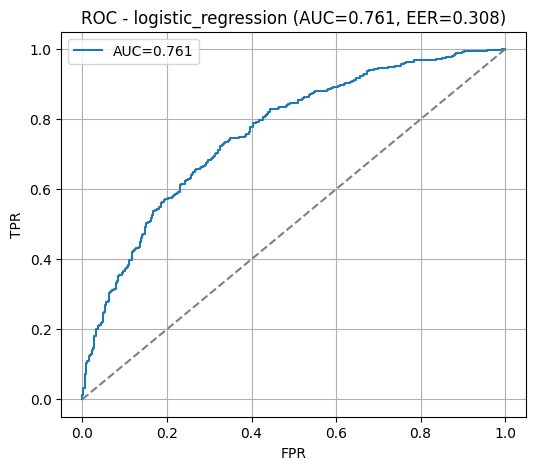

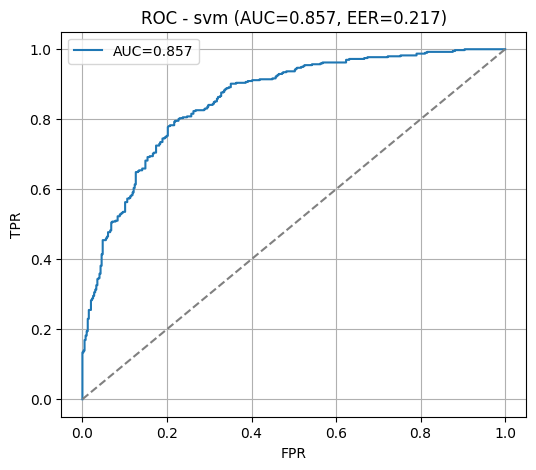


Model comparison:
                  model  accuracy       auc       eer   thr_eer
1                  svm  0.787879  0.857263  0.217172  0.482318
0  logistic_regression  0.691919  0.761376  0.308081  0.504109


In [18]:
# Cell 8: Full pipeline run

# Instantiate preprocessor and HOG
pre = Preprocessor(target_size=(128,64))
hog_ex = HOGExtractor(orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))

# Load dataset
ds = SignatureDatasetFromTwoFolders(SIGN_ROOT, pre, hog_ex)
ds.discover()
ds.summary(n_show=10)

# Build enrollment prototypes (for prototype verification evaluation)
ENROLL_K = 5
prototypes, enroll_paths = ds.build_enrollment_prototypes(enroll_k=ENROLL_K)
print(f"\nBuilt prototypes for {len(prototypes)} writers.")

# Build supervised dataset (HOG features) -- genuine -> 1, forgery -> 0
X, y_writer, filepaths = ds.compute_hog_features()
if X.shape[0] == 0:
    raise RuntimeError("No data found. Check SIGN_ROOT and folder structure.")

y_binary = np.array([0 if str(lbl).startswith('FORGERY_') else 1 for lbl in y_writer])
print(f"Total samples: {len(y_binary)} | Genuine: {y_binary.sum()} | Forgery: {len(y_binary)-y_binary.sum()}")

# Train/test split (stratified)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y_binary, np.arange(len(y_binary)), test_size=0.3, random_state=RANDOM_STATE, stratify=y_binary)

print(f"Train samples: {len(y_train)} | Test samples: {len(y_test)}")

# ModelTrainer with optional PCA (disable PCA by setting None)
trainer = ModelTrainer(scaler=StandardScaler(), pca=None, cv_folds=5)

# ---------- Logistic Regression ----------
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
lr_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    # 'solver': ['saga'],  # saga supports l2 and is fast
    # 'class_weight': ['balanced', None]
}
gs_lr = trainer.grid_search(lr, lr_grid, X_train, y_train, model_name='logistic_regression', scoring='roc_auc')

# ---------- SVM ----------
svm = SVC(probability=True, random_state=RANDOM_STATE)
svm_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01],
    # 'class_weight': ['balanced', None]
}
gs_svm = trainer.grid_search(svm, svm_grid, X_train, y_train, model_name='svm', scoring='roc_auc')

# # ---------- Random Forest ----------
# rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
# rf_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     # 'class_weight': ['balanced', None],
# }
# gs_rf = trainer.grid_search(rf, rf_grid, X_train, y_train, model_name='random_forest', scoring='roc_auc')

# # ---------- Gradient Boosting (sklearn) ----------
# gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
# gb_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.1, 0.05],
#     'max_depth': [3, 5]
# }
# gs_gb = trainer.grid_search(gb, gb_grid, X_train, y_train, model_name='gradient_boosting', scoring='roc_auc')

# Save best models to disk
for name, mdl in trainer.models.items():
    save_path = os.path.join(MODEL_DIR, f"{name}.joblib")
    joblib.dump(mdl, save_path)
    print(f"Saved {name} -> {save_path}")

# Evaluate all models on test set and collect results
comparison = []
for name in ['logistic_regression','svm',]:
    res = trainer.evaluate_on_test(name, X_test, y_test)
    auc = res['auc']; eer = res['eer']; acc = res['accuracy']
    comparison.append({'model': name, 'accuracy': acc, 'auc': auc, 'eer': eer, 'thr_eer': res['thr_eer']})
    # save ROC plot per model
    plot_roc(y_test, res['probs'], title=f"ROC - {name} (AUC={auc:.3f}, EER={eer:.3f})")
    # save probs and fpr/tpr if needed
    np.savez_compressed(os.path.join(OUT_DIR, f"{name}_test_scores.npz"),
                        probs=res['probs'], fpr=res['fpr'], tpr=res['tpr'], thresholds=res['thresholds'])

# Save comparison table to CSV
df_comp = pd.DataFrame(comparison).sort_values('auc', ascending=False)
df_comp.to_csv(os.path.join(OUT_DIR, "model_comparison.csv"), index=False)
print("\nModel comparison:\n", df_comp)
